In [118]:
import pandas as pd
import text_processing as text
from sklearn import metrics
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold, cross_val_predict, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV


df = pd.read_csv("movie_train.csv",index_col=0,)

df.reset_index(drop=False,inplace=True)
df.rename(mapper={'index':'ID'},axis=1,inplace=True)

print(df.shape)

df.head()




(10682, 7)


,ID,Release Year,Title,Plot,Director,Cast,Genre
0,10281,1984,Silent Madness,A computer error leads to the accidental relea...,Simon Nuchtern,"Belinda Montgomery, Viveca Lindfors",horror
1,7341,1960,Desire in the Dust,"Lonnie Wilson (Ken Scott), the son of a sharec...",Robert L. Lippert,"Raymond Burr, Martha Hyer, Joan Bennett",drama
2,10587,1986,On the Edge,"A gaunt, bushy-bearded, 44-year-old Wes Holman...",Rob Nilsson,"Bruce Dern, Pam Grier",drama
3,25495,1988,Ram-Avtar,Ram and Avtar are both childhood best friends....,Sunil Hingorani,"Sunny Deol, Anil Kapoor, Sridevi",drama
4,16607,2013,Machete Kills,Machete Cortez (Danny Trejo) and Sartana River...,Robert Rodriguez,"Danny Trejo, Michelle Rodriguez, Sofía Vergara...",action


In [5]:
skf = StratifiedKFold(n_splits=3)

X = df['Plot']
y = df['Genre']

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

In [7]:
text_clf = Pipeline([
     ('vect', CountVectorizer()),
     ('tfidf', TfidfTransformer()),
     ('clf', SGDClassifier(loss='hinge',penalty='l2',
                           alpha=1e-3, random_state=42,
                           n_jobs=-1)),
 ])

In [8]:
text_clf.fit(X_train, y_train)
predicted = text_clf.predict(X_test)
print(np.mean(predicted == y_test))

0.5657303370786517


In [9]:
parameters = {
     'vect__ngram_range': [(1, 1), (1, 2)],
     'tfidf__use_idf': (True, False),
     'clf__alpha': (1e-2, 1e-3),
 }

In [10]:
# Create grid search 
scorer = metrics.make_scorer(metrics.f1_score, average = 'weighted')
gs_clf = GridSearchCV(text_clf, parameters, cv=5, n_jobs=-1,scoring=scorer)

In [11]:
gs_clf = gs_clf.fit(X_train, y_train)

In [16]:
y_preds = gs_clf.predict(X_test)
print(metrics.accuracy_score(y_test,y_preds))
metrics.f1_score(y_test,y_preds,average='weighted')
pd.DataFrame(metrics.classification_report(y_test,y_preds,output_dict=True))

0.5783707865168539


,action,adventure,comedy,crime,drama,horror,romance,thriller,western,accuracy,macro avg,weighted avg
precision,0.581921,0.680000,0.590147,0.500000,0.536506,0.705263,0.447761,0.500000,0.801170,0.578371,0.593641,0.575588
recall,0.371841,0.154545,0.620044,0.036697,0.789809,0.717857,0.138889,0.052402,0.782857,0.578371,0.407216,0.578371
f1-score,0.453744,0.251852,0.604726,0.068376,0.638969,0.711504,0.212014,0.094862,0.791908,0.578371,0.425328,0.538709
support,277.000000,110.000000,908.000000,109.000000,1256.000000,280.000000,216.000000,229.000000,175.000000,0.578371,3560.000000,3560.000000


In [18]:
y_train_pred = cross_val_predict(gs_clf,X_train,y_train,cv=3)
conf_matrix = metrics.confusion_matrix(y_train,y_train_pred)



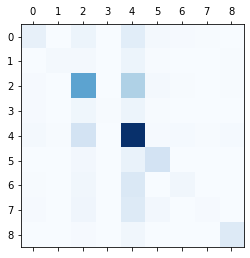

In [19]:
plt.matshow(conf_matrix,cmap=plt.cm.Blues)

plt.show()

In [20]:
import re, nltk, spacy, gensim

In [21]:
# def doc_to_words(docs):
#     for doc in docs:
#         yield(gensim.utils.simple_preprocess(str(doc), deacc=True))
        
# def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
#     """https://spacy.io/api/annotation"""
#     texts_out = []
#     nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
#     for sent in texts:
#         doc = nlp(" ".join(sent)) 
#         texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
#     return texts_out

# def pre_process(documents):
#     return lemmatization(doc_to_words(documents))

In [22]:
df['Processed_Plot'] = pre_process(df['Plot'])

In [23]:
## Trying the same thing again with a pre-processed corpus

X = df['Processed_Plot']
y = df['Genre']

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
text_clf = Pipeline([
     ('vect', CountVectorizer()),
     ('tfidf', TfidfTransformer()),
     ('clf', SGDClassifier(loss='hinge',penalty='l2',
                           alpha=1e-3, random_state=42,
                           n_jobs=-1)),
 ])

parameters = {
     'vect__ngram_range': [(1, 1), (1, 2)],
     'tfidf__use_idf': (True, False),
     'clf__alpha': (1e-2, 1e-3),
 }

gs_clf = GridSearchCV(text_clf, parameters, cv=5, n_jobs=-1,scoring=scorer)

gs_clf = gs_clf.fit(X_train, y_train)

y_preds = gs_clf.predict(X_test)

In [24]:
metrics.f1_score(y_test,y_preds,average='weighted')

0.5571440313931317

In [25]:
gs_clf.best_params_

{'clf__alpha': 0.01, 'tfidf__use_idf': True, 'vect__ngram_range': (1, 2)}

In [67]:
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import ADASYN, SMOTE, RandomOverSampler

In [99]:
sm_pipeline = make_pipeline(CountVectorizer(),
                            TfidfTransformer(),
                            SMOTE(n_jobs=-1,random_state=42),
                            SGDClassifier(n_jobs=-1,verbose=-1,random_state=42))

In [100]:
sm_pipeline.named_steps

{'countvectorizer': CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                 dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                 lowercase=True, max_df=1.0, max_features=None, min_df=1,
                 ngram_range=(1, 1), preprocessor=None, stop_words=None,
                 strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                 tokenizer=None, vocabulary=None),
 'tfidftransformer': TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True),
 'smote': SMOTE(k_neighbors=5, n_jobs=-1, random_state=42, sampling_strategy='auto'),
 'sgdclassifier': SGDClassifier(alpha=0.0001, average=False, class_weight=None,
               early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
               l1_ratio=0.15, learning_rate='optimal', loss='hinge',
               max_iter=1000, n_iter_no_change=5, n_jobs=-1, penalty='l2',
               power_t=0.5, random_state=42, shuffle=True, tol=0.001

In [105]:
sm_params = {
    'countvectorizer__ngram_range':[(1,1),(1,2)],
    'countvectorizer__max_df':[1,.9],
    'countvectorizer__min_df':[1,.9],
    'tfidftransformer__use_idf':[True,False],
    'tfidftransformer__smooth_idf':[True,False],
    'sgdclassifier__alpha':[.0001,.001],
    'sgdclassifier__loss':['hinge','log']
}

In [106]:
sm_search = GridSearchCV(sm_pipeline,sm_params,cv=5,n_jobs=-1,scoring=scorer,verbose=3)

In [107]:
def pipeline_cv(splits, X, Y, pipeline, average_method):
    
    kfold = StratifiedKFold(n_splits=splits, shuffle=True, random_state=777)
    accuracy = []
    precision = []
    recall = []
    f1 = []
    for train, test in kfold.split(X, Y):
        lr_fit = pipeline.fit(X[train], Y[train])
        prediction = lr_fit.predict(X[test])
        scores = lr_fit.score(X[test],Y[test])
        
        accuracy.append(scores * 100)
        precision.append(precision_score(Y[test], prediction, average=average_method)*100)
        #print('              negative    neutral     positive')
        print('precision:',precision_score(Y[test], prediction, average=None))
        recall.append(recall_score(Y[test], prediction, average=average_method)*100)
        print('recall:   ',recall_score(Y[test], prediction, average=None))
        f1.append(f1_score(Y[test], prediction, average=average_method)*100)
        print('f1 score: ',f1_score(Y[test], prediction, average=None))
        print('-'*50)

    print("accuracy: %.2f%% (+/- %.2f%%)" % (np.mean(accuracy), np.std(accuracy)))
    print("precision: %.2f%% (+/- %.2f%%)" % (np.mean(precision), np.std(precision)))
    print("recall: %.2f%% (+/- %.2f%%)" % (np.mean(recall), np.std(recall)))
    print("f1 score: %.2f%% (+/- %.2f%%)" % (np.mean(f1), np.std(f1)))

In [108]:
pipeline_cv(3,X,y,sm_search,'weighted')

Fitting 5 folds for each of 128 candidates, totalling 640 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:   59.9s
//anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 488 tasks      | elapsed: 10.1min
[Parallel(n_jobs=-1)]: Done 640 out of 640 | elapsed: 11.4min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


Convergence after 8 epochs took 3.24 seconds
Convergence after 9 epochs took 3.60 seconds
Convergence after 9 epochs took 3.69 seconds


[Parallel(n_jobs=-1)]: Done   2 out of   9 | elapsed:    3.6s remaining:   12.6s


Convergence after 10 epochs took 3.86 seconds
Convergence after 10 epochs took 3.93 seconds
Convergence after 11 epochs took 4.05 seconds
Convergence after 11 epochs took 4.07 seconds
Convergence after 12 epochs took 4.13 seconds
Convergence after 13 epochs took 4.19 seconds


[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    4.2s finished


precision: [0.45308311 0.47663551 0.62628337 0.39285714 0.69858871 0.61460957
 0.41111111 0.37142857 0.69642857]
recall:    [0.6101083  0.46363636 0.67180617 0.3        0.55131265 0.87142857
 0.51388889 0.22807018 0.89142857]
f1 score:  [0.52       0.47004608 0.64824655 0.34020619 0.6162739  0.72082718
 0.45679012 0.2826087  0.78195489]
--------------------------------------------------
Fitting 5 folds for each of 128 candidates, totalling 640 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:   59.9s
//anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 488 tasks      | elapsed: 10.5min
[Parallel(n_jobs=-1)]: Done 640 out of 640 | elapsed: 12.0min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


Convergence after 8 epochs took 3.39 seconds
Convergence after 9 epochs took 3.78 seconds
Convergence after 9 epochs took 3.83 seconds


[Parallel(n_jobs=-1)]: Done   2 out of   9 | elapsed:    3.8s remaining:   13.4s


Convergence after 10 epochs took 4.12 seconds
Convergence after 11 epochs took 4.21 seconds
Convergence after 11 epochs took 4.20 seconds
Convergence after 11 epochs took 4.30 seconds
Convergence after 12 epochs took 4.33 seconds
Convergence after 13 epochs took 4.39 seconds


[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    4.4s finished


precision: [0.46991404 0.47272727 0.64912281 0.37179487 0.69223206 0.63002681
 0.3465704  0.32544379 0.68949772]
recall:    [0.5942029  0.46846847 0.69273128 0.26605505 0.56006364 0.83928571
 0.44239631 0.24122807 0.86285714]
f1 score:  [0.5248     0.47058824 0.67021843 0.31016043 0.61917326 0.71975498
 0.38866397 0.27707809 0.76649746]
--------------------------------------------------
Fitting 5 folds for each of 128 candidates, totalling 640 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:   57.8s
//anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 488 tasks      | elapsed: 10.1min
[Parallel(n_jobs=-1)]: Done 640 out of 640 | elapsed: 11.5min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


Convergence after 8 epochs took 3.30 seconds
Convergence after 9 epochs took 3.79 seconds
Convergence after 9 epochs took 3.85 seconds


[Parallel(n_jobs=-1)]: Done   2 out of   9 | elapsed:    3.8s remaining:   13.3s


Convergence after 10 epochs took 4.10 seconds
Convergence after 10 epochs took 4.19 seconds
Convergence after 11 epochs took 4.35 seconds
Convergence after 12 epochs took 4.40 seconds
Convergence after 12 epochs took 4.44 seconds
Convergence after 13 epochs took 4.48 seconds


[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    4.5s finished


precision: [0.45504087 0.45714286 0.60322256 0.4        0.69034995 0.60552764
 0.35099338 0.31818182 0.75242718]
recall:    [0.60288809 0.43636364 0.65969163 0.25688073 0.5183121  0.86071429
 0.49074074 0.24454148 0.88571429]
f1 score:  [0.51863354 0.44651163 0.63019463 0.31284916 0.59208731 0.71091445
 0.40926641 0.27654321 0.81364829]
--------------------------------------------------
accuracy: 58.37% (+/- 0.84%)
precision: 59.43% (+/- 0.62%)
recall: 58.84% (+/- 0.87%)
f1 score: 58.37% (+/- 0.84%)


In [117]:
joblib.dump(sm_search.best_estimator_,'model_2.pkl')

['model_2.pkl']

In [122]:
y_preds = sm_search.predict(X_test)
pd.DataFrame(metrics.classification_report(y_test,y_preds,output_dict=True))

,action,adventure,comedy,crime,drama,horror,romance,thriller,western,accuracy,macro avg,weighted avg
precision,0.725904,0.803571,0.834213,0.824742,0.908273,0.846154,0.700787,0.813725,0.884211,0.839045,0.815731,0.844662
recall,0.870036,0.818182,0.870044,0.733945,0.804140,0.942857,0.824074,0.724891,0.960000,0.839045,0.838685,0.839045
f1-score,0.791461,0.810811,0.851752,0.776699,0.853041,0.891892,0.757447,0.766744,0.920548,0.839045,0.824488,0.839301
support,277.000000,110.000000,908.000000,109.000000,1256.000000,280.000000,216.000000,229.000000,175.000000,0.839045,3560.000000,3560.000000


In [125]:
cross_val_score(sm_search,X_test,y_test)

Fitting 5 folds for each of 128 candidates, totalling 640 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:   34.4s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 488 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 640 out of 640 | elapsed:  4.6min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   9 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    0.1s finished


Convergence after 7 epochs took 0.07 seconds
Convergence after 7 epochs took 0.07 seconds
Convergence after 8 epochs took 0.07 seconds
Convergence after 8 epochs took 0.08 seconds
Convergence after 8 epochs took 0.08 seconds
Convergence after 8 epochs took 0.08 seconds
Convergence after 8 epochs took 0.08 seconds
Convergence after 9 epochs took 0.08 seconds
Convergence after 10 epochs took 0.09 seconds
Fitting 5 folds for each of 128 candidates, totalling 640 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:   32.7s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 488 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 640 out of 640 | elapsed:  4.6min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   9 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    0.1s finished


Convergence after 7 epochs took 0.07 seconds
Convergence after 8 epochs took 0.07 seconds
Convergence after 8 epochs took 0.08 seconds
Convergence after 8 epochs took 0.08 seconds
Convergence after 8 epochs took 0.08 seconds
Convergence after 8 epochs took 0.08 seconds
Convergence after 8 epochs took 0.08 seconds
Convergence after 9 epochs took 0.08 seconds
Convergence after 9 epochs took 0.09 seconds
Fitting 5 folds for each of 128 candidates, totalling 640 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:   32.6s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 488 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 640 out of 640 | elapsed:  4.6min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   9 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    0.1s finished


Convergence after 7 epochs took 0.06 seconds
Convergence after 7 epochs took 0.06 seconds
Convergence after 8 epochs took 0.07 seconds
Convergence after 8 epochs took 0.07 seconds
Convergence after 8 epochs took 0.07 seconds
Convergence after 8 epochs took 0.08 seconds
Convergence after 8 epochs took 0.08 seconds
Convergence after 9 epochs took 0.08 seconds
Convergence after 10 epochs took 0.09 seconds
Fitting 5 folds for each of 128 candidates, totalling 640 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:   32.3s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 488 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 640 out of 640 | elapsed:  4.6min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   9 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    0.1s finished


Convergence after 7 epochs took 0.06 seconds
Convergence after 7 epochs took 0.06 seconds
Convergence after 7 epochs took 0.06 seconds
Convergence after 8 epochs took 0.07 seconds
Convergence after 8 epochs took 0.07 seconds
Convergence after 8 epochs took 0.07 seconds
Convergence after 8 epochs took 0.08 seconds
Convergence after 9 epochs took 0.08 seconds
Convergence after 9 epochs took 0.09 seconds
Fitting 5 folds for each of 128 candidates, totalling 640 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:   33.0s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 488 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 640 out of 640 | elapsed:  4.6min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   9 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    0.1s finished


Convergence after 7 epochs took 0.07 seconds
Convergence after 7 epochs took 0.07 seconds
Convergence after 7 epochs took 0.07 seconds
Convergence after 8 epochs took 0.08 seconds
Convergence after 8 epochs took 0.08 seconds
Convergence after 8 epochs took 0.08 seconds
Convergence after 8 epochs took 0.08 seconds
Convergence after 9 epochs took 0.08 seconds
Convergence after 10 epochs took 0.09 seconds


array([0.5704714 , 0.54829878, 0.57731173, 0.55489976, 0.55049717])